## Import Libraries

In [1]:
import pandas as pd                                  #to import the dataset
import numpy as np                                   #to perform statistical operations
from tqdm import tqdm, tqdm_notebook                 #to track progress
import seaborn as sns                                #to plot statistics
import matplotlib.pyplot as plt                      #to plot statistics  
from datetime import datetime                        #to aid in time statistics
import folium                                        #to aid in location statistics
from matplotlib.colors import ListedColormap         #plotting

## Data Import

### Source datasets to be used for data analysis

In [2]:
app_events = pd.read_csv("../dataset/app_events.csv")
app_labels = pd.read_csv("../dataset/app_labels.csv")
events = pd.read_csv("../dataset/events.csv")
label_categories = pd.read_csv("../dataset/label_categories.csv")
device_details = pd.read_csv("../dataset/phone_brand_device_model.csv")
train_devices = pd.read_csv("../dataset/gender_age_train.csv")
test_devices = pd.read_csv("../dataset/gender_age_test.csv")

In [3]:
print(app_events.columns)
print(app_labels.columns)
print(events.columns)
print(label_categories.columns)
print(device_details.columns)
print(train_devices.columns)
print(test_devices.columns)

Index(['event_id', 'app_id', 'is_installed', 'is_active'], dtype='object')
Index(['app_id', 'label_id'], dtype='object')
Index(['event_id', 'device_id', 'timestamp', 'longitude', 'latitude'], dtype='object')
Index(['label_id', 'category'], dtype='object')
Index(['device_id', 'phone_brand', 'device_model'], dtype='object')
Index(['device_id', 'gender', 'age', 'group'], dtype='object')
Index(['device_id'], dtype='object')


### Processed dataset containing records in the format described below

In [4]:
df = pd.read_pickle("../dataset/dataset_records.pkl")

In [5]:
print(df.columns)

Index(['device_id', 'brand', 'model', 'installed_apps', 'activity'], dtype='object')


This dataset has records of all the device_ids(Both Train and Test). It contains:
1. Device_id - unique identifier for the device.
2. Brand - The Brand of the Mobile device manufacturer.
3. Model - The model of the Mobile device.
4. Installed_apps - Unique Identifiers(IDs) of all the apps installed on the mobile device.
5. Mobile Activity - This contains a list of app activity on the mobile device. It gives us which app was active at which time on the phone and at which place on the map. This is not a list of the complete app activity on the device but it is what is available to us.

## Data Cleaning

### Dropping Duplicate device_ids 

In [6]:
df.drop_duplicates('device_id', inplace=True) 

### We convert brand and model names given in Chinese to English language

In [7]:
#load the dictionary containing Chinese to English translation
brand_english = np.load('translation/brand_english.npy', allow_pickle=True).item()

In [8]:
#load the dictionary containing Chinese to English translation
model_english = np.load('translation/model_english.npy', allow_pickle=True).item()

In [9]:
#Functions to apply the translation to the records in the dataset
def chinese_to_english(row):
    """Function thtat translates Chinese words to English words if present in the dictionary. Else returns the same word."""
    if row['brand'] in brand_english.keys():
        row['brand'] = str(brand_english[row['brand']])
        
    if row['model'] in model_english.keys():
        row['model'] = str(model_english[row['model']])
    
    return row

In [10]:
# It is used to skip the warning ''SettingWithCopyWarning''.. 
pd.options.mode.chained_assignment = None  # default='warn'

tqdm.pandas()
df = df.progress_apply(chinese_to_english, axis = 1)

100%|████████████████████████████████████████████████████████████████████████| 186716/186716 [00:25<00:00, 7404.14it/s]


### Splitting into training and test reords

In [11]:
#Getting train and test devices
df_train = df[df['device_id'].isin(train_devices['device_id'])]
df_test = df[df['device_id'].isin(test_devices['device_id'])]

In [12]:
print(df_train.head(2))

             device_id   brand  model installed_apps activity
0 -8890648629457979026  Xiaomi  Redmi             {}       []
1  1277779817574759137  Xiaomi   MI 2             {}       []


### Getting target variables for the training records

In [13]:
print(df_train.columns)

Index(['device_id', 'brand', 'model', 'installed_apps', 'activity'], dtype='object')


In [14]:
df_train = df_train.merge(train_devices, left_on='device_id', right_on='device_id')

In [15]:
print(df_train.columns)

Index(['device_id', 'brand', 'model', 'installed_apps', 'activity', 'gender',
       'age', 'group'],
      dtype='object')


## Data Analysis

### Utility Functions

In [16]:
def stack_chart_groups(attr, df):
    """"Function which gives a stacked plot for the atrivute passed"""

    columns= list(df[attr].value_counts()[:10].index)
    columns.insert(0, 'group')

    df_plot = pd.DataFrame(columns=columns)
    
    for i in list(df['group'].drop_duplicates()):
    
        attr_list = []
        
        for j in list(df[attr].value_counts()[:10].index): 
    
            attr_list.append(df[(df['group']==i) & (df[attr]==j)].shape[0])
                
        attr_list = [x/sum(attr_list) for x in attr_list]
        attr_list.insert(0, i)
        
        df_plot.loc[len(df_plot)] = attr_list
        
    sns.set()
    df_plot.set_index('group').T.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(20,8))
    plt.xlabel(attr)
    plt.ylabel("Percentage Scale")
    plt.show()

In [17]:
def stack_activity_time(df, attr="activity_hour"):
    """Function that plots the daily/weekly app activity of Users based on Gender/Age/App Type. 
    Setting appropriate variables and passing appropriate conditions is necessasry"""
    
    if attr == "activity_hour":
        columns= list(range(24))
    else:
        columns= list(range(7))
        
    columns.insert(0, 'group')

    df_plot = pd.DataFrame(columns=columns)
    
    grp_timestamps = []
     
    #Based on gender. 'M'/'F' to be passed as parameter gc
    for i in list(df['group'].drop_duplicates()):
        if attr == "activity_hour":
            timestamps = [0.0 for x in range(24)]
        else:
            timestamps = [0.0 for x in range(7)]
        for index, row in df[df['group']==i].iterrows():
            if sum(row[attr])!=0:
                perc_activity = [x/sum(row[attr]) for x in row[attr]]
                timestamps = [a + b for a, b in zip(timestamps, perc_activity)]
        
        timestamps = [y/sum(timestamps) for y in timestamps]
        timestamps.insert(0,i)
        df_plot.loc[len(df_plot)] = timestamps
            
    sns.set()
    
    ax = df_plot.set_index('group').T.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(20,8))
    if attr == "activity_hour":
        plt.xlabel("Hour of Day")
    else:
        plt.xlabel("Day of Week")
    plt.ylabel("Percentage Scale")
    plt.show()

In [18]:
def stack_chart_travels(df):
    """Function which gives a stacked plot for the Number of travels"""

    columns= ['group','1-5','5-20','20-50','50+']
    
    df_plot = pd.DataFrame(columns=columns)
    
    for i in list(df['group'].drop_duplicates()):
        travels = [0 for x in range(4)]
        for index, row in df[df['group']==i].iterrows():
            if (row['num_travels']>0)&(row['num_travels']<=6):
                travels[0] += 1
            elif (row['num_travels']>5)&(row['num_travels']<=20):
                travels[1] += 1
            elif (row['num_travels']>20)&(row['num_travels']<=50):
                travels[2] += 1
            elif row['num_travels']>50:
                travels[3] += 1            
            
        travels = [x/sum(travels) for x in travels]    
        travels.insert(0, i)
        
        df_plot.loc[len(df_plot)] = travels
        
    sns.set()
    df_plot.set_index('group').T.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(20,8))
    plt.xlabel("Number of Travels")
    plt.ylabel("Percentage Scale")
    plt.show()

In [19]:
def stack_chart_app_usage(df, session=False):
    """Function which gives a stacked plot for app_usage and app_usage_per_session"""
    
    if session:
        attr = "app_usage_session"
    else:
        attr = "app_usage"

    columns= ['group','<0.1','0.1-0.25','0.25-0.5','0.5-0.8','0.8+']
    
    df_plot = pd.DataFrame(columns=columns)
    
    for i in list(df['group'].drop_duplicates()):
        usage = [0 for x in range(5)]
        for index, row in df[(df['group']==i)&(df[attr]!=0.0)].iterrows():
            if row[attr]<0.1:
                usage[0] += 1
            if (row[attr]>0.1)&(row[attr]<=0.25):
                usage[1] += 1
            elif (row[attr]>0.25)&(row[attr]<=0.5):
                usage[2] += 1
            elif (row[attr]>0.5)&(row[attr]<=0.8):
                usage[3] += 1
            elif row[attr]>0.8:
                usage[4] += 1            
            
        usage = [x/sum(usage) for x in usage]    
        usage.insert(0, i)
        
        df_plot.loc[len(df_plot)] = usage
        
    sns.set()
    df_plot.set_index('group').T.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(20,8))
    if session:
        plt.xlabel("App Usage per Session")
    else:
        plt.xlabel("App Usage")
    plt.ylabel("Percentage Scale")
    plt.show()

### Devices Statistics

In [20]:
print("Number of train device_ids: ", df_train.shape[0])
print("Number of testn device_ids: ", df_test.shape[0])

Number of train device_ids:  74645
Number of testn device_ids:  112071


### Event Data Availability

In [21]:
print("Percentage of train records containing event data: ", df_train[df_train.astype(str)['activity']!='[]'].shape[0]/ df_train.shape[0]*100)
print("Percentage of test records containing event data: ", df_test[df_test.astype(str)['activity']!='[]'].shape[0]/ df_test.shape[0]*100)

Percentage of train records containing event data:  31.143412150847343
Percentage of test records containing event data:  31.306939350947165


Therefore, we have app activity for only 31.14% of the total records/users. For all the other records/users, we have only mobile brand and model information.

### Target Distribution

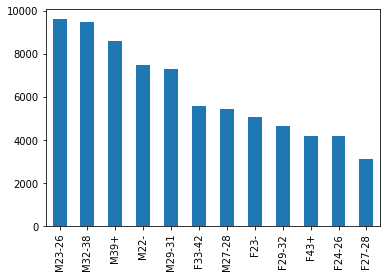

In [22]:
df_train['group'].value_counts().plot(kind='bar')

This is somewhat an unbalanced dataset

### Brand Statistics

In [23]:
print("Number of unique phone brands: ", len(list(df_train['brand'].drop_duplicates())))

Number of unique phone brands:  119


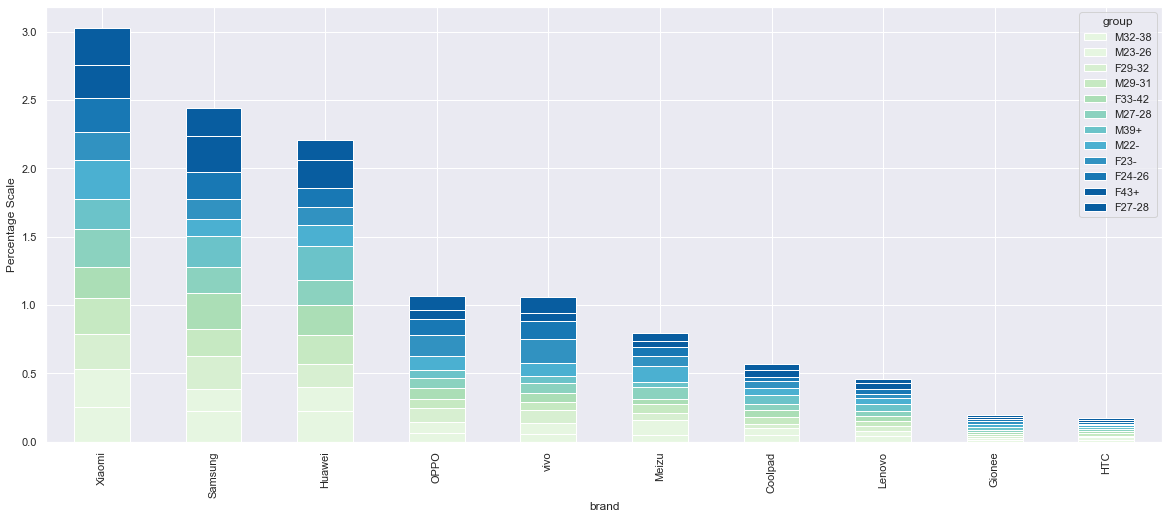

In [24]:
stack_chart_groups('brand', df_train)

### Model Statistics

In [25]:
print("Number of unique phone models: ", len(list(df_train['model'].drop_duplicates())))

Number of unique phone models:  1433


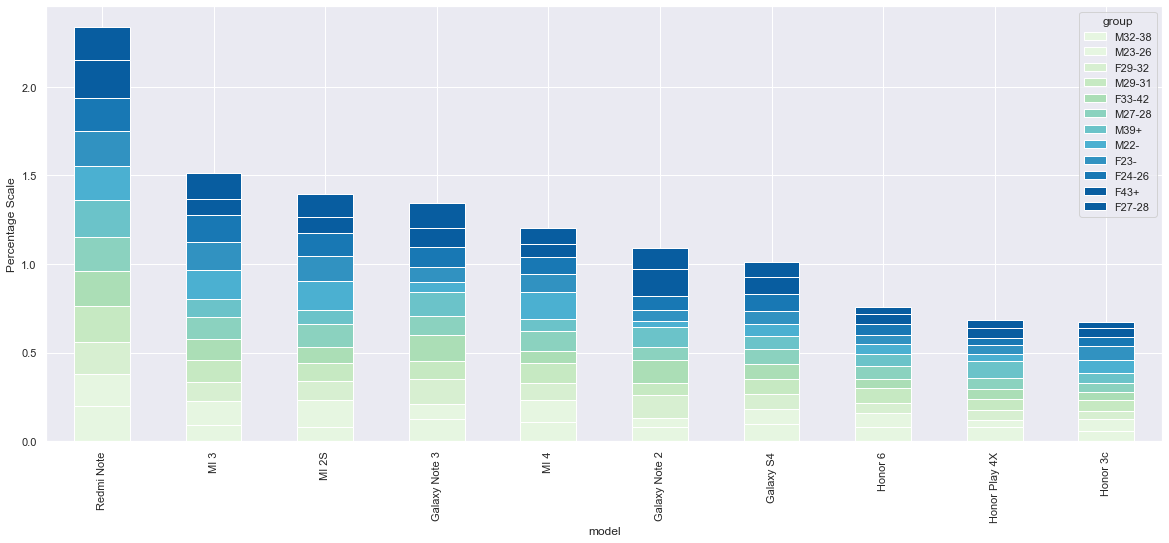

In [26]:
stack_chart_groups('model', df_train)

### App Statistics

In [27]:
#list of apps in central repository
print("Number of unique apps: ", len(list(app_labels['app_id'].drop_duplicates())))

Number of unique apps:  113211


In [28]:
apps = []

for i in df_train['installed_apps'].values:
    apps.extend(i)

In [29]:
#list of apps installed by our user group
print("Number of unique apps installed by the User group:", len(set(apps)))

Number of unique apps installed by the User group: 13762


Of the number of unique apps (113211) available(probably from a central repository such as playstore), our subset of users have installed only a small percentage(12.15%) of the total apps availble.

### App Category Statistics

In [30]:
print("Number of unique category of apps: ", label_categories.shape[0])

Number of unique category of apps:  930


In [31]:
app_category_counts = app_labels['label_id'].value_counts() 

In [40]:
app_categories = {i:[] for i in app_labels['app_id'].unique()}

for i in tqdm(list(app_categories.keys())):
    app_categories[i] = set(app_labels[app_labels['app_id']==i]['label_id'])

100%|████████████████████████████████████████████████████████████████████████| 113211/113211 [01:21<00:00, 1395.25it/s]


In [46]:
def return_categories(row):
    """Function that gets the app type/category for each app installed on the device."""
    
    cats = []
    for i in row['installed_apps']:
        cats.extend(app_categories[i])
        
    if len(cats)>0:
        return set(cats)
    else:
        return []

In [47]:
tqdm.pandas()
df_train['installed_app_categories'] = df_train.progress_apply(return_categories, axis = 1)
df_test['installed_app_categories'] = df_test.progress_apply(return_categories, axis = 1)

100%|███████████████████████████████████████████████████████████████████████| 112071/112071 [00:03<00:00, 35259.32it/s]


In [49]:
cats_dict = {}

for i in tqdm(df_train['installed_app_categories']):
    if i:
        for j in i:
            if j in cats_dict.keys():
                cats_dict[j] += 1
            else:
                cats_dict[j] = 1

100%|████████████████████████████████████████████████████████████████████████| 74645/74645 [00:00<00:00, 187580.25it/s]


In [50]:
print("Number of unique category of apps installed by our user group: ", len(cats_dict))

Number of unique category of apps installed by our user group:  485


Out of the 930 different categories of apps present in the central repository, our User group only uses apps from 485 categories(52.1%)

In [51]:
def app_usage(row):
    """This function determines the fraction of active apps used by a User w.r.t all the installed apps.
    It also determines the average fraction of active apps per session."""
    
    row['app_usage'] = 0
    row['app_usage_session'] = 0
    row['active_app_categories'] = []
    row['active_app_usage_time'] = 0
    row['active_apps'] = {}
    
    if row.astype(str)['activity']!='[]':
        
        installed_apps_count = len(set(row['installed_apps']))
        used_apps = []
        used_apps_per_session = []
        previous_timestamp = row['activity'][0][1]
        app_count = 0
        
        active_app_usage = {i:[0 for i in range(24)] for i in cats_dict.keys()}
        active_app_count = {i:0 for i in cats_dict.keys()}
        
        cats = []
        
        for activity in row['activity']:
            
            time = datetime.strptime(activity[1], '%Y-%m-%d %H:%M:%S')
            
            for i in app_categories[activity[0]]:
                if i in cats_dict.keys():
                    cats.append(i)
                    active_app_usage[i][time.hour] += 1
            
            used_apps.append(activity[0])
            if activity[1]==previous_timestamp:
                app_count += 1
            else:
                used_apps_per_session.append(app_count/installed_apps_count)
                app_count = 1
                previous_timestamp=activity[1]
        
        if len(used_apps_per_session)==0:
            used_apps_per_session.append(app_count/installed_apps_count)
        
        used_apps = set(used_apps)
        
        row['active_apps'] = used_apps
        row['active_app_categories'] = set(cats)
        row['active_app_usage_time'] = active_app_usage
        row['app_usage'] = len(set(used_apps))/installed_apps_count
        row['app_usage_session'] = np.mean(used_apps_per_session)
        
    return row

In [52]:
tqdm.pandas()
df_train = df_train.progress_apply(app_usage, axis = 1)
df_test = df_test.progress_apply(app_usage, axis = 1)

100%|█████████████████████████████████████████████████████████████████████████| 112071/112071 [08:25<00:00, 221.75it/s]


### App Usage

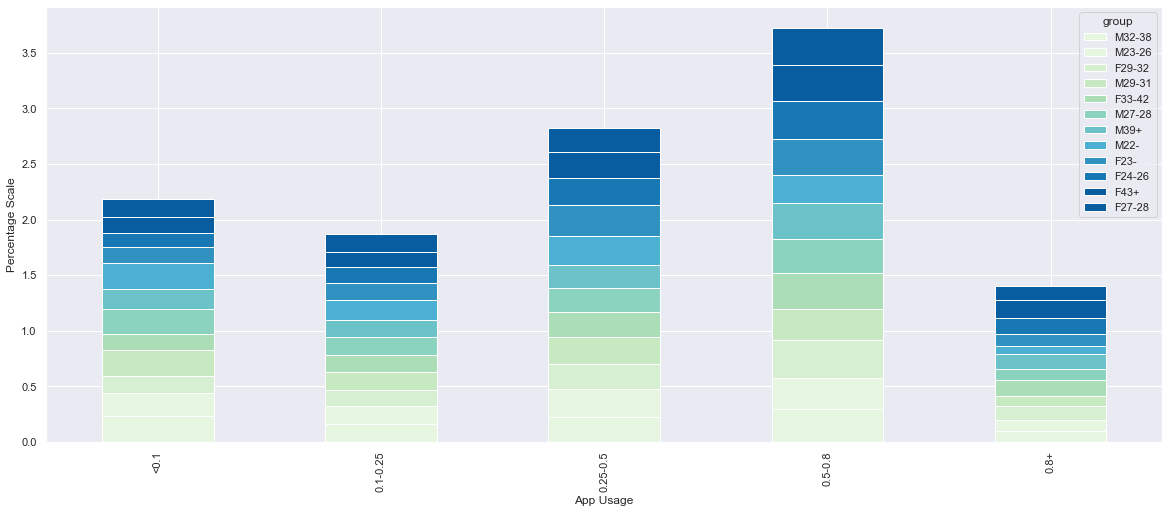

In [53]:
stack_chart_app_usage(df_train)

### App Usage per Session

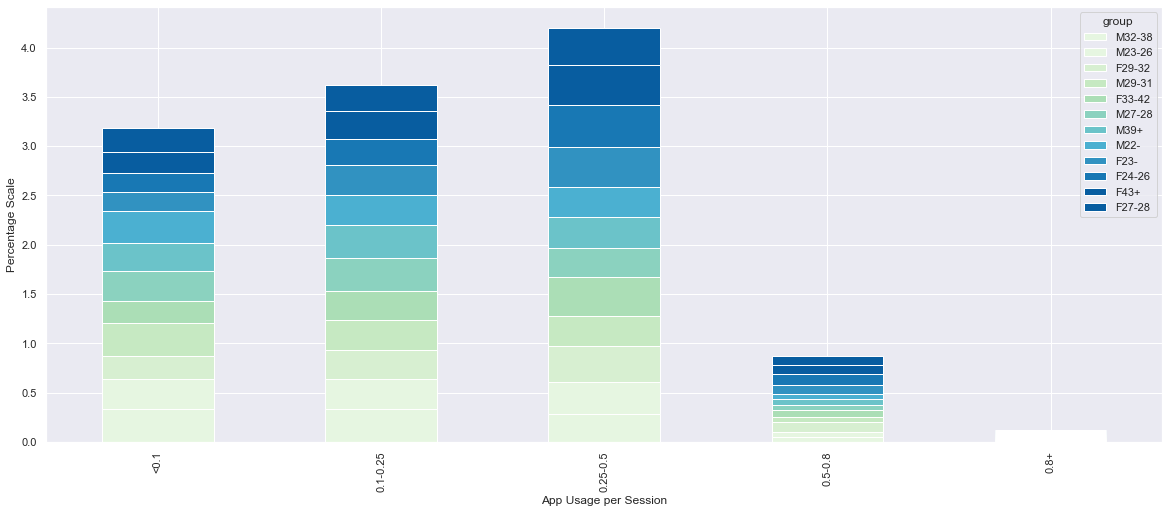

In [54]:
stack_chart_app_usage(df_train, session=True)

## Time Statistics

In [55]:
print(events['timestamp'].min(), events['timestamp'].max())

2016-04-30 23:52:24 2016-05-08 00:00:08


This dataset contains records that span between 23:52:24 hours of 30-04-2016 to 00:00:08 hours of 2016-05-08. That is, it spans a length of 7 days, 7 minutes and 44 secs.

In [56]:
def get_day_hour_activity(row):
    """Function that gets the time based activity information(both day and week) for a device"""
    day_of_week = {key: 0 for key in range(7)}
    hour_of_day = {key: 0 for key in range(24)}
        
    if(len(row['activity'])>0):
            
        for activity in row['activity']:
            time = datetime.strptime(activity[1], '%Y-%m-%d %H:%M:%S')
            day_of_week[time.weekday()] += 1
            hour_of_day[time.hour] += 1
            
    row['activity_hour'] = list(hour_of_day.values())
    row['activity_day'] = list(day_of_week.values())
    
    return row

In [57]:
tqdm.pandas()
df_train = df_train.progress_apply(get_day_hour_activity, axis = 1)
df_test = df_test.progress_apply(get_day_hour_activity, axis = 1)

100%|█████████████████████████████████████████████████████████████████████████| 112071/112071 [03:47<00:00, 491.93it/s]


### Hour Of Day Activity

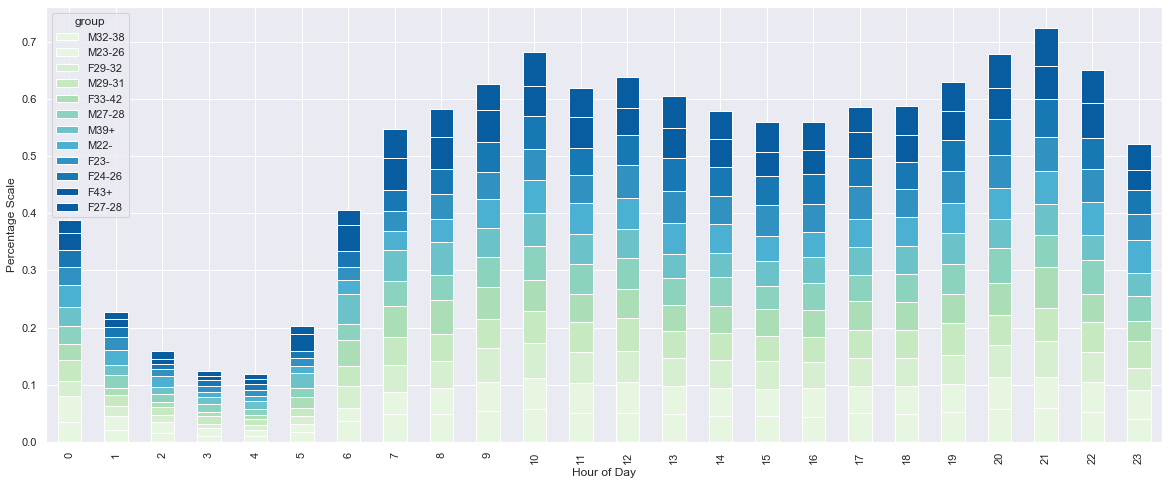

In [58]:
stack_activity_time(df_train)

### Day Of Week Activity

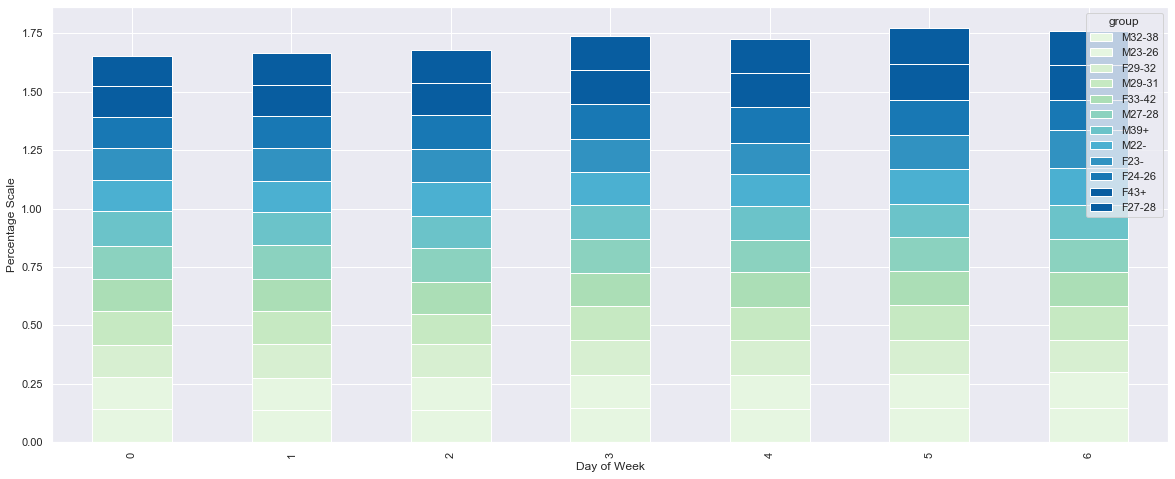

In [59]:
stack_activity_time(df_train, attr="activity_day")

The male and female app activity is consistent with the overall app activity which follows the following pattern:

Hour of Day

1. There is a dip in activity during late night hours(0000 to 0500 hours)
2. There is an increase in activity from early morning hours to afternoon hours(0500 to 1200 hours)
3. There is a slight dip in activity in the afternoon hours(1200 to 1600 hours)
4. There is again an increase in activity in the evening hours to the night hours(1600 to 2100 hours)
5. There is a dip in activity in the late night hours(2200 to 0000 hours)

Day of Week

1. The activity peaks during mid week. Activity is less on weekend compared to weekdays.
2. 0 is Sunday, 6 is Saturday.

## Location Statistics

As can be seen below, there seems to be a sharp outlier at (0.0, 0.0). This can be because of three reasons:
1. Either a lot of users are active near (0.0, 0.0) location. This is not possible because the location is in the Atlantic ocean.
2. It is an outlier. Data may not have been collected properlyor some fault at the device end.
3. Users might have used VPN during the app activity and that VPN might have routed the traffic through a server present in the location (0.0, 0.0)

The second set continuous distribution represents the range of latitude and longitude coordinates covering China

In [60]:
map_osm = folium.Map(location=[0.0, 0.0], tiles='Stamen Toner')
folium.Marker(list((0.0,0.0))).add_to(map_osm)
map_osm

In [61]:
#getting 100 random devices that have app data
sample_points = df_train[df_train['activity'].astype(str)!='[]'].sample(n=100)

In [62]:
#plotting 100 random device locations
map_osm = folium.Map(location=[events['latitude'].median(), events['longitude'].median()], tiles='Stamen Toner')

for index, row in sample_points.iterrows():
    folium.Marker(list(row['activity'][0][2])).add_to(map_osm)

map_osm

As can be seen, many of the device locations are in China(as it should be) since TalkingData is China’s largest third-party mobile data platform. Also, we can spot a number of outliers in the location (0.0, 0.0) as discussed above.

## Number of Travels

In [63]:
#threshold is the difference in latitude we use to detect travel/movement. A threshold of 0.01 = 1.1132 kms, 1.0 = 111.32 kms. 
#This can be adjusted to decide how much of a movement can be termed as travel

def detect_location_travels(row):
    """This function is used to determine the number of travels a user has made, the user's mean latitude and longitude 
    coordinates. The mean latitude and longitude coordinates will be same for a stationary User and differs for travelling users.     
    The term travel refers to movement across a certain threshold distance which can be controlled. 
    Here, the threshold is as stated above(111.32 kms)"""
    
    threshold=1.0
    num_travels=0
    
    lats=[0.0]
    longs=[0.0]
        
    if(len(row['activity'])>0):
        previous_activity = row['activity'][0][2]
        for activity in row['activity']:
            current_activity=activity[2]
            
            if current_activity!=(0.0,0.0):                #to remove the outllier
                lats.append(current_activity[0])
                longs.append(current_activity[1])
                
            if (abs(previous_activity[0]-current_activity[0])>threshold) or (abs(previous_activity[1]-current_activity[1])>threshold):
                if (previous_activity!=(0.0,0.0) and current_activity!=(0.0,0.0)):             #to remove the outllier
                    num_travels += 1
            previous_activity=current_activity
    
    
    mean_lat = np.mean(lats)
    mean_long = np.mean(longs)
    
    row['num_travels'] = num_travels
    row['mean_latitude'] = mean_lat
    row['mean_longitude'] = mean_long
    
    return row

In [64]:
tqdm.pandas()
df_train = df_train.progress_apply(detect_location_travels, axis = 1)
df_test = df_test.progress_apply(detect_location_travels, axis = 1)

100%|█████████████████████████████████████████████████████████████████████████| 112071/112071 [03:57<00:00, 471.17it/s]


### Number of Travels

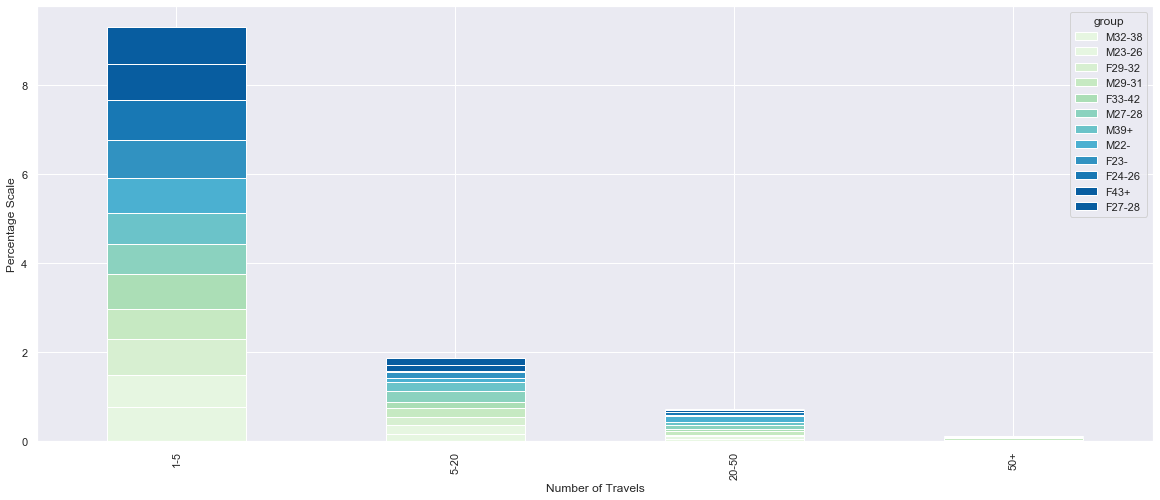

In [65]:
stack_chart_travels(df_train)

Not included the number of users that dont travel as its extremely high(close to 70K). Above are the statistics for users who seem to travel more than 100kms in the time period (7days, 7hours calculate above) 

In [66]:
print(df_train.columns)

Index(['device_id', 'brand', 'model', 'installed_apps', 'activity', 'gender',
       'age', 'group', 'installed_app_categories', 'app_usage',
       'app_usage_session', 'active_app_categories', 'active_app_usage_time',
       'active_apps', 'activity_hour', 'activity_day', 'num_travels',
       'mean_latitude', 'mean_longitude'],
      dtype='object')


In [67]:
#since test dataset does not have target variables, age, gender and group
print(df_train.shape)
print(df_test.shape)

(74645, 19)
(112071, 16)


In [68]:
#save processed data to disk
df_train.to_pickle("dataset/dataset_train.pkl")
df_test.to_pickle("dataset/dataset_test.pkl")